# Description
This notebook uses LIME to make post-hoc explanations of classifications.<br>
LIME stands for local interpretable model-agnostic explanations .<br>

See 
- https://github.com/marcotcr/lime
- [example tensorflow notebook](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images.ipynb)
- https://arxiv.org/abs/1602.04938
- [useful resnet example](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

Another alternative is to use SHAP (SHapley Additive exPlanations): https://github.com/slundberg/shap



# Setup

In [1]:
#imports

import numpy as np
from tensorflow.keras.applications import resnet50 as res_net

from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

import lime
from lime import lime_image

import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


2023-07-08 22:09:19.182459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Model and Parameters

In [2]:
# Load the resnet model
model = res_net.ResNet50()


2023-07-08 22:09:21.635092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 22:09:21.636324: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# Set input image size used by model
image_size=(224, 224) 

# Form Preprocessing Function

In [4]:
#res_net.preprocess_input: 
#    1) converts from RGB to BGR, then
#    2) each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
preprocess = res_net.preprocess_input 


In [5]:
########################################
# inv_preprocess function
#
# Inputs [I] & Outputs [O]:
# [I] processed_img: image that has been processed by resnet50 preprocessing 
# [O] img_out: image that has inverse-preprocessed (inverse of resnet50 preprocessing)
#
# Description
#
#   specific to resnet50 "caffe" mode
#   see https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
#
# Resnet50 pre-processing details:
#   the images are converted from RGB to BGR, then 
#   each color channel is zero-centered with respect to the ImageNet dataset, without scaling 
#   mean values used for zero-centering each channel are [103.939, 116.779, 123.68]
#     see https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L135

def inv_preprocess(processed_img): 
    img_out = processed_img.copy().astype('double') #deep copy so we make sure not to change something we don't intend to
    # (Remove zero-center by mean pixel)
    img_out[:, :, 0] += 103.939
    img_out[:, :, 1] += 116.779
    img_out[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img_out = img_out[:, :, ::-1]
    img_out = np.clip(img_out, 0, 255).astype('uint8')
    return img_out


# Load Data & Examine

In [6]:
n=56
image_path = "/home/dm/ml_n_code/sandbox/cats_vs_dogs/data/train/Cat/" + str(n)+".jpg"


In [7]:
img_raw = image.load_img(image_path, target_size=image_size)
x = image.img_to_array(img_raw)
x = np.expand_dims(x, axis=0)
x = preprocess(x) 

out = []
out.append(x)
data=np.vstack(out)


np.min(data[0]),np.max(data[0]) 

(-119.68, 138.061)

(2, 246)

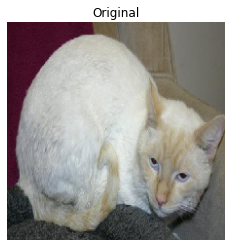

In [8]:
#check input image
plt.imshow(img_raw)
plt.axis("off")
plt.title("Original")
np.min(img_raw),np.max(img_raw)

(2, 246)

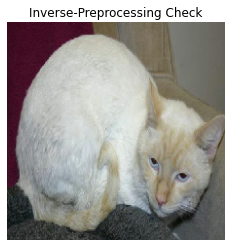

In [9]:
#spot-check inverse-preprocessing function
plt.imshow(inv_preprocess(data[0]))
plt.axis("off")
plt.title("Inverse-Preprocessing Check")
np.min(inv_preprocess(data[0])),np.max(inv_preprocess(data[0]))

(0, 255)

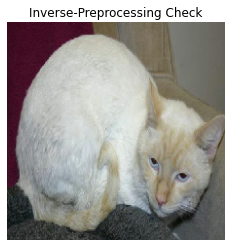

In [10]:
plt.imshow(inv_preprocess(data[0]).astype('uint8'))
plt.axis("off")
plt.title("Inverse-Preprocessing Check")
np.min(data[0].astype('uint8')),np.max(data[0].astype('uint8'))


# Find Prediction(s)

In [11]:
preds = model.predict(data)
print('Predicted:')
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
for x in decode_predictions(preds)[0]:
    print(x)

1/1 [==============================] - 1s 892ms/step
Predicted:
('n02123597', 'Siamese_cat', 0.30703264)
('n03223299', 'doormat', 0.124315314)
('n02328150', 'Angora', 0.06341783)
('n03958227', 'plastic_bag', 0.031275555)
('n02971356', 'carton', 0.024824232)


# Prediction Function

In [12]:
def preprocess_n_predict(x): 
    x = preprocess(x) 
    return model.predict(x)



# Find Explanations

In [13]:
# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()


In [14]:
# Explain the prediction
explanation = explainer.explain_instance(
    #data[0].astype('uint8'), #messes up segmentation alg since data is not 0 to 255
    #data[0].astype('double'), #messes up segmentation alg since data is not -1.0 to 1.0
    inv_preprocess(data[0]), #undo preprocessing to make data 0 to 255 for segmentation
    preprocess_n_predict,  #preprocesses again and then predict 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 778ms/step


Text(0.5, 1.0, 'Explanation Explanation')

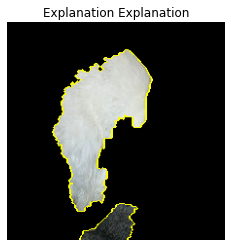

In [15]:
#see the explanation for the top class -- just show positive parts
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
#plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title("Explanation Explanation")


Text(0.5, 1.0, 'Segmentation')

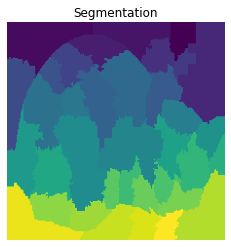

In [16]:
#show region segmentation
plt.figure()
plt.imshow(explanation.segments)
plt.axis("off")
plt.title('Segmentation')

Text(0.5, 1.0, 'Mask')

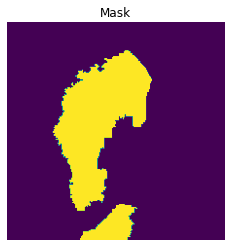

In [17]:
#show region label mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.title('Mask')

Text(0.5, 1.0, 'Explanation with Rest of Image')

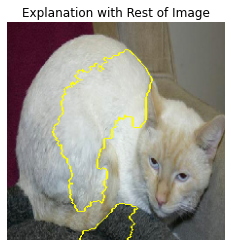

In [18]:
#see the explanation for the top class -- with the rest of the image present
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
#plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Explanation Pros (Green) and Cons (Red)')

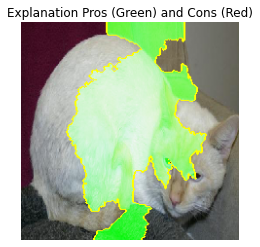

In [19]:
#see the 'pros and cons' (pros contributing to class call in green, cons in red)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)
#plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title('Explanation Pros (Green) and Cons (Red)')

Text(0.5, 1.0, 'Explanation Heatmap')

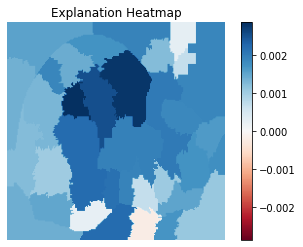

In [20]:
#explanation weights heatmap visualization

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis("off")
plt.title('Explanation Heatmap')

In [21]:
explanation.top_labels[0]

284